In [1]:
# Purpose: Plotting CTD data 
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         
#     Maurice F. Huguenin, m.huguenin-virchaux@unsw.edu.au, 10. 05. 2021      #                                                
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #

# % preamble ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         
save = 'Y:/Maurice Huguenin/in2021_v3/figures/'

import xarray as xr # for working with labelled multi-dimensional arrays                                                                
import numpy as np # for numerical operations                                                           
import cmocean as cm
from datetime import datetime # package for printing time in plot                                       
import string # for subplot annotation                                                                  
import matplotlib.pyplot as plt # for matlab-like plotting                                              
import cartopy.crs as ccrs # for maps     
import itertools
import pandas as pd
import cmocean
from matplotlib import gridspec
from matplotlib import ticker
import cartopy.mpl.ticker as cticker
import matplotlib.dates as mdates
import string # for subplot annotation
import cartopy.feature as cfeature
from matplotlib import gridspec
import gsw # TEOS-10 package from Trevor McDougal

import cftime

from dask.distributed import Client
client = Client(n_workers=4)         # careful: do not run with 48 workers here as it will crash
client
rotblau = [[0.4 , 0.  , 0.12], [0.47, 0.02, 0.13], [0.62, 0.07, 0.16], [0.66, 0.16, 0.2],
           [0.8 , 0.3 , 0.27], [0.87, 0.44, 0.35], [0.93, 0.58, 0.45], [0.96, 0.7 , 0.58], 
           [0.98, 0.8 , 0.71], [0.98, 0.94, 0.92], [0.93, 0.95, 0.96], [0.85, 0.91, 0.95],
           [0.76, 0.87, 0.93], [0.64, 0.8 , 0.89], [0.49, 0.72, 0.84], [0.34, 0.62, 0.79], 
           [0.23, 0.53, 0.74], [0.16, 0.44, 0.7] , [0.1 ,0.35, 0.6], [0.05, 0.24, 0.45], [0.02, 0.19, 0.38]]

C:\Users\Maurice Huguenin\.conda\envs\pyn_env\lib\site-packages\distributed\dashboard\core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


### Plotting as depth, longitude transects (much like the Triaxus)

CTD cast: 017
['2021-05-23T03:24:32.806998528']
--- --- --- --- ---
CTD cast: 018
['2021-05-23T04:09:38.435000320']
--- --- --- --- ---
CTD cast: 019
['2021-05-23T04:54:29.848002048']
--- --- --- --- ---
CTD cast: 020
['2021-05-23T05:42:18.225000448']
--- --- --- --- ---
CTD cast: 021
['2021-05-23T06:31:03.680999936']
--- --- --- --- ---
CTD cast: 022
['2021-05-23T07:31:23.140003840']
--- --- --- --- ---
CTD cast: 023
['2021-05-23T08:26:42.343997952']
--- --- --- --- ---
CTD cast: 024
['2021-05-23T09:36:20.307002880']
--- --- --- --- ---
Wall time: 10.1 s


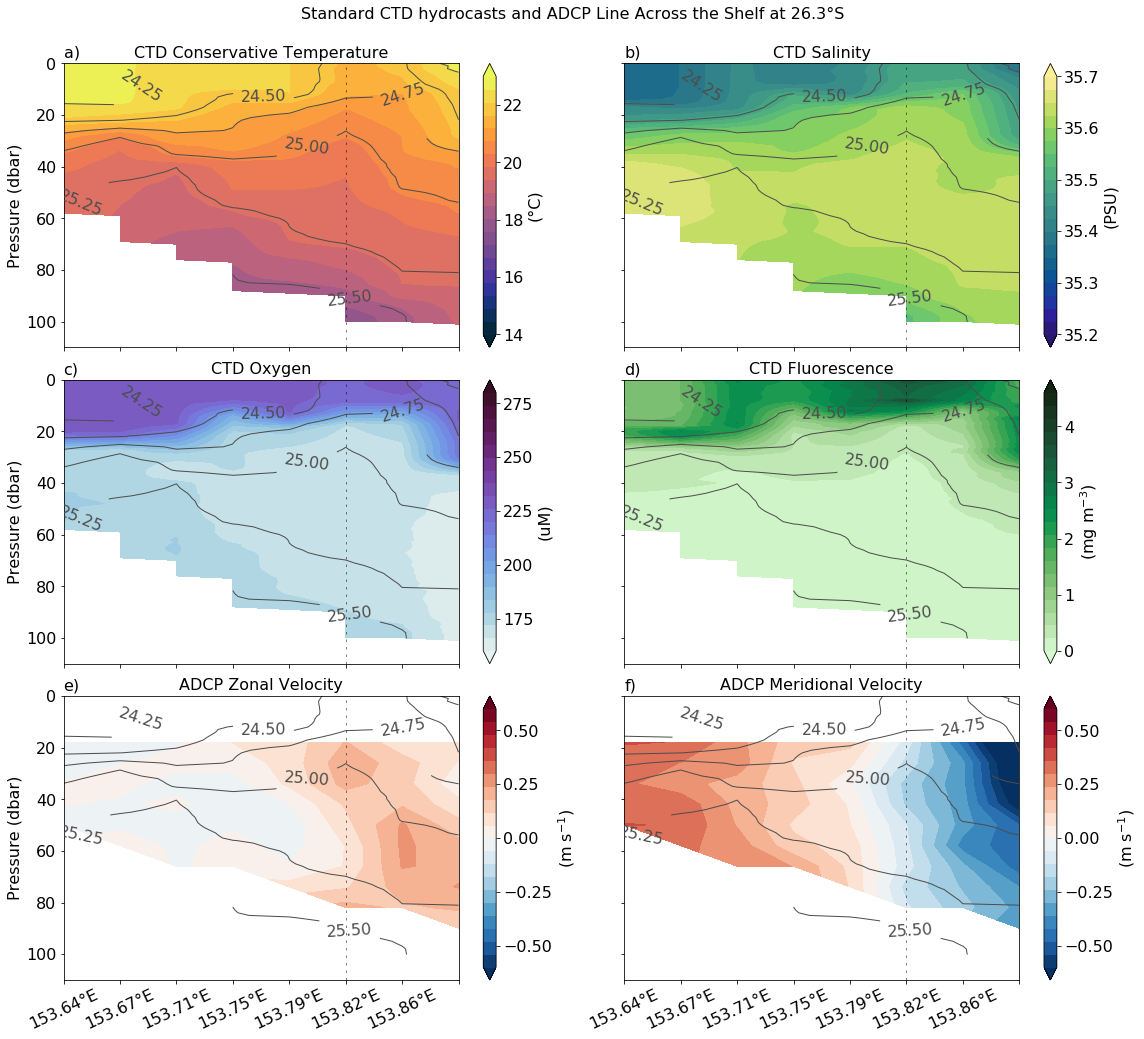

In [2]:
%%time
base = 'W:/in2021_v03/ctd/processing/in2021_v03/cap/cappro/avg/'
base2 = 'W:/in2021_v03/adcp/uhdas/proc/os150nb/contour/' # path to ADCP data set

CTD8 = xr.open_dataset(base + 'in2021_v030' + str(24) + 'CtdAvg.nc') # open reference data set with the deepest depth

temp  = np.zeros(shape=(len(CTD8.pressure.values),8)) # get the data structure, eight rows with x number of values in depth
sal   = np.zeros(shape=(len(CTD8.pressure.values),8))  # next, we will fill in these empty arrays
oxy   = np.zeros(shape=(len(CTD8.pressure.values),8))
fluor = np.zeros(shape=(len(CTD8.pressure.values),8))

ds = xr.open_dataset(base2 + 'os150nb.nc') # the ADCP data set
depth = xr.open_dataset(base2 + 'os150nb.nc').depth[0,:] # depth from the ADCP
X, Y = np.meshgrid(depth,[0,1,2,3,4,5,6,7]) # create 2-D meshgrids of depth and the eight longitude values from the CTD

u = np.zeros(shape=(8, len(depth))) # empty arrays that get filled up
v = np.zeros(shape=(8, len(depth)))


# initalise empty longitude array which gets filled up
longitude = np.zeros(shape=(8,1))

for f in range(17,25,1): # cycle through CTD casts #017 to #024
    print('CTD cast: 0' + str(f))
    CTD = xr.open_dataset(base + 'in2021_v030' + str(f) + 'CtdAvg.nc') # string only v03010, v2011, ect.

    # fill up the empty arrays with data from the CTD casts 17 to 24
    temp[0:len(CTD.temperature[0,0,:,0]),f-17] = CTD.temperature[0,0,:,0]
    temp[temp == 0] = 'nan' # set all zeroes to nan
    sal[0:len(CTD.salinity[0,0,:,0]),f-17] = CTD.salinity[0,0,:,0]
    sal[sal == 0] = 'nan' # set all zeroes to nan
    oxy[0:len(CTD.oxygen[0,0,:,0]),f-17] = CTD.oxygen[0,0,:,0]
    oxy[oxy == 0] = 'nan' # set all zeroes to nan
    fluor[0:len(CTD.fluorometer[0,0,:,0]),f-17] = CTD.fluorometer[0,0,:,0]
    fluor[fluor == 0] = 'nan' # set all zeroes to nan
    
    longitude[f-18] = np.round(CTD.longitude.values,2) # longitude values
    print(CTD.time.values)
    print('--- --- --- --- ---')    

    # select only the ADCP data when we did a CTD cast, i.e., only four vertical columns
    u[f-17,:] = xr.open_dataset(base2 + 'os150nb.nc').u.sel(time=CTD.time.values, method='nearest')
    v[f-17,:] = xr.open_dataset(base2 + 'os150nb.nc').v.sel(time=CTD.time.values, method='nearest')

# Create empty grid of zeros for density surfaces
dens = np.zeros(shape=(len(CTD8.pressure.values),8))
# Calculate density
for i in range(len(temp)): # loop over depth levels
    for j in range(8): # loop over CTD casts
        dens[i,j]=gsw.rho(sal[i,j],temp[i,j],0)
dens = dens-1000 # convert to sigma, i.e., subtract 1000 kg/m3 

    
# Color bars for the subplot panels
farbe = [cmocean.cm.thermal, cmocean.cm.haline, cmocean.cm.dense, cmocean.cm.algae,
        'RdBu_r', 'RdBu_r']


# initialise figure
fig = plt.figure(figsize=(16,14),tight_layout=True,facecolor='w',edgecolor='k')
gs = gridspec.GridSpec(3, 2, width_ratios = [1,1])

for s in range(6): # cycle through four subplots

    if s == 0:   # Temperature
        panel = gs[0,0]; data = temp; ticks = np.linspace(14,23,21)
        titel = 'CTD Conservative Temperature'; unit = '°C'
    if s == 1:   # Salinity
        panel = gs[0,1]; data = sal; ticks = np.linspace(35.2,35.7,21)
        titel = 'CTD Salinity'; unit = 'PSU'
    if s == 2:   # Oxygen
        panel = gs[1,0]; data = oxy; ticks = np.linspace(160,280,21)
        titel = 'CTD Oxygen'; unit = 'uM'    
    if s == 3:   # Oxygen
        panel = gs[1,1]; data = fluor; ticks = np.linspace(0,4.6,21)
        titel = 'CTD Fluorescence'; unit = 'mg m$^{-3}$'    
    if s == 4:   # u Velocity
        panel = gs[2,0]; data = u; ticks = np.linspace(-.6,.6,21)
        titel = 'ADCP Zonal Velocity'; unit = 'm s$^{-1}$'   
    if s == 5:   # u Velocity
        panel = gs[2,1]; data = v; ticks = np.linspace(-.6,.6,21)
        titel = 'ADCP Meridional Velocity'; unit = 'm s$^{-1}$'   

        
    ax1 = plt.subplot(panel)
    if s in [0,1,2,3]: # plot contours of CTD data
        plt.contourf(data, CTD.pressure, levels=ticks, cmap=farbe[s], extend='both'); cb = plt.colorbar()

    if s in [4,5]: # add ADCP in panels 5 and 6
        plt.contourf(Y, X, data, levels=ticks, cmap=farbe[s], extend='both'); cb = plt.colorbar()

    # vertical line indicating the eddy center
    ax1.axvline(x=5, linewidth=.5, c = 'k', linestyle=(0,(5,10)))

    
    # plot density contours in dark grey
    p11 = plt.contour(dens, levels = [24,24.25,24.5,24.75,25,25.25,25.5], 
                      linewidths=1.0, colors=[[.3,.3,.3]]) # dark grey colour
    plt.clabel(p11, inline_spacing=1, fontsize=16, fmt="%.2f")


    plt.ylim(top=110)  # adjust the bottom leaving top unchanged
    plt.yticks(fontsize=16); plt.xticks(fontsize=16) # ticklabel  size

    # add subplot label, i.e., a), b), c), d), ...
    ax1.text(0, 1.02, string.ascii_lowercase[s]+')', transform=ax1.transAxes, size=16, weight='normal') # bold letter a at the top
    plt.title(titel, fontsize = 16, loc='center') # title

    cb.set_label(label='('+unit+')', size=16) # colour bar label
    cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=5) # change parameters for the colour bar
    cb.locator = tick_locator; cb.update_ticks()

    if s in [0,1,2,3]: # adjust the x axis ticks so that they start at 1 instead of 0
        plt.xticks(np.arange(len(temp[0,:])), np.arange(1, len(temp)+1)) # adjust xticklabels so that they start at 1 instead of 0
    plt.gca().invert_yaxis() # invert y-axis
    if s in [4,5]: # custom longitude labels
        labels = [item.get_text() for item in ax1.get_xticklabels()] # get x ticks
        labels = [str(longitude[0][0])+'°E', str(longitude[1][0])+'°E', str(longitude[2][0])+'°E', 
                  str(longitude[3][0])+'°E', str(longitude[4][0])+'°E',
                  str(longitude[5][0])+'°E', str(longitude[6][0])+'°E']
        
        
#        labels = ['2','3','4','5','6','7'] # create custom ones
        ax1.set_xticklabels(labels, rotation = 25) # replace labels
#    if s in [2,3]:
#        plt.xlabel('Shallow CTD Cast', fontsize=16) # axis labels
    if s in [0,2,4]: plt.ylabel('Pressure (dbar)', fontsize=16) # axis labels
    if s in [0,1,2,3]: ax1.set_xticklabels([])
    if s in [1,3,5]: ax1.set_yticklabels([])
    
    if s in [4,5]:
        plt.ylim(bottom=110, top=0)  # adjust the bottom leaving top unchanged

#    ax1.axvline(x=5, linewidth=3, c = 'grey')

# plot over the full figure
plt.figtext(.5, 1.02, CTD.DeploymentType + 's and ADCP Line Across the Shelf at ' + 
            "%.1f" % np.abs(CTD.latitude.values)+'°S',
            ha='center', va='center', fontsize=16)
        
        
# save figure
plt.savefig('X:/FIGURES/' + 'CTD_Hydrocast_CTD_line_together_2', dpi=300, facecolor='w',
            edgecolor='w', orientation='landscape',
            format=None, transparent=False, bbox_inches='tight', 
            pad_inches=0.1, metadata=None)
# --- end of script --------------------------------------------------------- #

In [3]:
temp

array([[22.91998969, 22.67785937, 22.20610644, ..., 21.57308946,
        21.7147833 , 22.88899676],
       [22.919598  , 22.6769157 , 22.20641083, ..., 21.54651893,
        21.73019113, 22.68637132],
       [22.91889578, 22.67126782, 22.2063061 , ..., 21.51865325,
        21.72035193, 22.70572933],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan, 15.00547572],
       [        nan,         nan,         nan, ...,         nan,
                nan, 14.99579945],
       [        nan,         nan,         nan, ...,         nan,
                nan, 14.9865063 ]])

### Now adding TS-Diagrams

In [4]:
%%time
# load in temperature and salinity at the very beginning of the trend, i.e. in 2006-01
import datashader as ds
import datashader.transfer_functions as tf

temp2 = temp.reshape(1,-1)[0] # convert to degrees C

salt2 = sal.reshape(1,-1)[0]
oxy2 = oxy.reshape(1,-1)[0]

#where_are_NaNs = np.isnan(oxy2); oxy2[where_are_NaNs] = 0 # replace nan with zero

# Default plot ranges:
y_range = (-2, 31) # temperature
x_range = (28,38) # salinity

df = pd.DataFrame({'temp': temp2, 'salt' : salt2, 'oxy' : oxy2}, copy=False)

def create_image(x_range=x_range, y_range=y_range, w=500, h=500):
    cvs = ds.Canvas(x_range=x_range, y_range=y_range, plot_height=h, plot_width=w)
    agg = cvs.points(df, 'salt', 'temp', 'oxy')
    return tf.shade(agg)

cvs = ds.Canvas(plot_width=500, plot_height=500, x_range=x_range, y_range=y_range)
agg2 = cvs.points(df, 'salt', 'temp')

img = tf.shade(agg2, cmap=plt.cm.YlOrRd)
# Wall time: 28.6 s

Wall time: 5.14 s


### Plotting Routine

<a list of 9 text.Text objects>

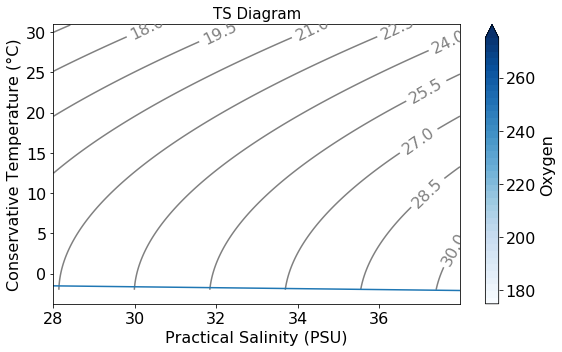

In [5]:
# initialise figure
        
fig = plt.figure(figsize=(8, 5),tight_layout=True,facecolor='w',edgecolor='k')

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

ticks = np.linspace(175,275,num=41) # ticks for colour bar

ax1 = plt.subplot(1,1,1)

p2 = agg2.plot.contourf(cmap=plt.cm.Blues,levels=ticks,
                                 add_colorbar=False,extend='max')

# add colour bar
cb = plt.colorbar(p2, shrink=1); cb.set_label(label='Oxygen', size=16)
cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=5) # five ticks on colour bar
cb.locator = tick_locator;cb.update_ticks()

plt.title('TS Diagram', fontsize=15) # title
#ax1.text(0, 1.05,string.ascii_lowercase[0]+')', transform=ax1.transAxes, 
#            size=16, weight='normal') # bold letter a at the top

ax1.set_xlabel('Practical Salinity (PSU)', fontsize = 16)
ax1.set_ylabel('Conservative Temperature (°C)', fontsize = 16)

ax1.tick_params(axis='both', which='major', labelsize=16) # fontsize of lon/lat labels

# plot isopycnals on top
temp = np.arange(-2,31, .1) # creating arrays for plotting the isopycnal and freezing point contours
salt = np.arange(28, 38, .01)
plt.plot(salt, gsw.CT_freezing(salt, 10.1325, 0)) # freezing point contour, pressure = 10.1325 dbar and saturation_fraction=0 - you can modify the 
temp_mesh,salt_mesh = np.meshgrid(temp, salt)
density = gsw.density.sigma0(salt_mesh, temp_mesh) # using surface density pot_rho_0

contours = plt.contour(salt_mesh, temp_mesh, density, 10, colors='grey')
plt.clabel(contours, inline=True,  inline_spacing =1,fontsize=16,  fmt='%1.1f')

# --------------------------------------------------------------------------- #
# --- saving as 300 dpi .PNG image in specified folder ---------------------- #
# --- end of script --------------------------------------------------------- #
#plt.savefig(save + 'ACCESS-OM2-1_TS_Diagram_OHC_trend', dpi=300, facecolor='w', 
#            edgecolor='w', orientation='landscape', papertype=None, 
#            format=None, transparent=False, bbox_inches=None, 
#            pad_inches=0.1, metadata=None)
# --- end of script --------------------------------------------------------- #

# Wall time: 1min 33s

In [6]:
# ----------------------------------------------------------------------------------------------------------------------- #
#                                                   Notes down below                                                      #
# ----------------------------------------------------------------------------------------------------------------------- #

In [7]:
agg2


<xarray.DataArray (temp: 500, salt: 500)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint32)
Coordinates:
  * salt     (salt) float64 28.01 28.03 28.05 28.07 ... 37.93 37.95 37.97 37.99
  * temp     (temp) float64 -1.967 -1.901 -1.835 -1.769 ... 30.83 30.9 30.97

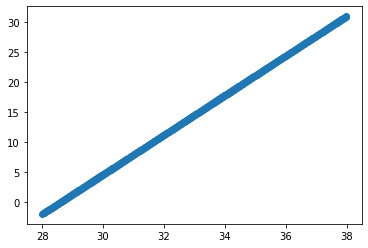

In [8]:
plt.scatter(agg2.salt,agg2.temp,cmap=plt.cm.Blues)#),levels=ticks, add_colorbar=False,extend='max')